In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# dl kaggle data - https://www.kaggle.com/datasets/kutayahin/stackoverflow-programming-questions-2020-2025

import os
import kagglehub

dir = kagglehub.dataset_download('dhruvildave/en-fr-translation-dataset')
filename = 'en-fr.csv'
filepath = os.path.join(dir, filename)

In [3]:
import torch

torch.manual_seed(12)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(12)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# extract data

import pandas as pd
from transformers import AutoTokenizer


CSV_PATH = filepath
BATCH_SIZE = 8
N = 2048
N_TEST = 2048
D_MODEL = 512
D_V = 64
TOKENIZER = AutoTokenizer.from_pretrained("t5-small", model_max_length=N) 


# extract raw data
def extract(batch_size: int = BATCH_SIZE, csv_path: str = CSV_PATH) -> tuple[list[str], list[str]]:
    chunk_iterator = pd.read_csv(
        csv_path, 
        chunksize=batch_size * 10, # secure enough data
        header=None,
        names=['en','fr'],
        usecols=['en', 'fr'],
        on_bad_lines='skip',
        na_filter=True,
        skiprows=[0, 1, 2, 3, 4, 5], # drop rows w/ irrelevant data
        skip_blank_lines=True,
    )
    first_chunk = next(chunk_iterator)
    raw_en = first_chunk['en'].astype(str).tolist()
    raw_fr = first_chunk['fr'].astype(str).tolist()
    raw_en_sentences, raw_fr_sentences = list(), list()
    for i, item in enumerate(raw_en):
        if len(item.split(' ')) > 1 and i < batch_size: 
            raw_en_sentences.append(item)
            raw_fr_sentences.append(raw_fr[i])
    return raw_en_sentences, raw_fr_sentences

en_raw, fr_raw = extract()


In [5]:
# attention modules - standard, mha, mqa, gqa

from typing import Optional
import torch as t
import torch.nn as nn
import torch.nn.functional as F


class StandardAttention(nn.Module):
    def __init__(self, d_model: int = 512, d_V: int = 64, projection: bool = True) -> None: # d_model - dim of the model input layer, d_v - dim of value vector
        super().__init__()
        self.d_model = d_model
        self.d_V = d_V
        self.projection = projection
        self.scaling_factor = 1 / t.sqrt(t.tensor(self.d_V, requires_grad=False))
        self.query = nn.Linear(in_features=self.d_model, out_features=self.d_V, bias=True)
        self.key = nn.Linear(in_features=self.d_model, out_features=self.d_V, bias=True)
        self.value = nn.Linear(in_features=self.d_model, out_features=self.d_V, bias=True)
        self.output_proj = nn.Linear(in_features=self.d_V, out_features=self.d_model, bias=False) # output projection layer

    def self_attention(self, Q: t.Tensor, K: t.Tensor, V: t.Tensor, mask: Optional[t.BoolTensor] = None) -> t.Tensor:       
        K_T = t.transpose(K, -1, -2)  # [b, N, D]
        S = t.matmul(Q, K_T) * self.scaling_factor  # attention score
        if mask is not None: S = t.masked_fill(S, mask==0, -t.inf) # mask (if any)
        A = t.softmax(S, dim=-1) # attention weight
        Z = t.matmul(A, V)  # context vector
        return Z

    def forward(self, x: t.Tensor, mask: Optional[t.BoolTensor] = None) -> t.Tensor:
        Q = self.query(x) # [b, N, D_V]
        K = self.key(x) # [b, N, D_V]
        V = self.value(x) # [b, N, D_V]
        Z = self.self_attention(Q, K, V, mask=mask) # [b, N, D_V]
        O = self.output_proj(Z) if self.projection else Z # [b, N, d_model] 
        return O



# https://arxiv.org/abs/1706.03762
class MHA(nn.Module):
    def __init__(self, d_model: int = 512, d_V: int = 64, H: int = 8) -> None: # H: total heads 
        super().__init__()
        # input features: H * d_V. output features: d_model
        self.proj = nn.Linear(in_features=H * d_V, out_features=d_model, bias=False) 
        self.multihead = nn.ModuleList([StandardAttention(d_model, d_V, False) for _ in range(H)])
    
    def forward(self, x: t.Tensor, mask: Optional[t.BoolTensor] = None) -> t.Tensor:
        Z = t.cat([head(x, mask) for head in self.multihead], dim=2) 
        O = self.proj(Z)
        return O



# https://arxiv.org/pdf/1911.02150.pdf
class MQA(StandardAttention):
    def __init__(self, d_model: int = 512, d_V: int = 64, n_queries: int = 8) -> None:
        super().__init__(d_model, d_V)
        self.n_queries = n_queries
        self.proj = nn.Linear(in_features=d_V * n_queries, out_features=d_model, bias=False) 
        delattr(self, 'query') # remove inherited query

        self.queries = nn.ModuleList([nn.Linear(in_features=d_model, out_features=d_V, bias=True) for _ in range(n_queries)])
        self.key = nn.Linear(in_features=d_model, out_features=d_V, bias=True)
        self.value = nn.Linear(in_features=d_model, out_features=d_V, bias=True)

    
    def forward(self, x: t.Tensor, mask: Optional[t.BoolTensor] = None) -> t.Tensor:
        K = self.key(x)
        V = self.value(x)
        Z = t.cat([self.self_attention(query(x), K, V, mask) for query in self.queries], dim=2)
        O = self.proj(Z)
        return O



# https://arxiv.org/pdf/2305.13245.pdf
class GQA(StandardAttention):
    def __init__(self, d_model: int = 512, d_V: int = 64, n_groups: int = 4, n_queries: int = 2) -> None: # n_queries (for each group
        super().__init__(d_model, d_V)
        delattr(self, 'query')
        delattr(self, 'key')
        delattr(self, 'value')
        self.groups = nn.ModuleList([MQA(d_model=d_model, d_V=d_V, n_queries=n_queries) for _ in range(n_groups)])
        self.proj = nn.Linear(in_features=d_model * n_groups, out_features=d_model, bias=False)

    def forward(self, x: t.Tensor, mask: Optional[t.BoolTensor] = None) -> t.Tensor:
        Z = t.cat([head(x, mask) for head in self.groups], dim=2)
        O = self.proj(Z)
        return O


In [6]:
# encoder module + positional encoding
import math
import torch as t
import torch.nn as nn


class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int):
        super().__init__()

        # compute the positional encodings (pe) once in log space
        pe = t.zeros(max_len, d_model)
        position = t.arange(0, max_len, dtype=t.float).unsqueeze(1)
        div_term = t.exp(t.arange(0, d_model, 2).float() * ( - math.log(10000.0) / d_model))
        pe[:, 0::2] = t.sin(position * div_term)
        pe[:, 1::2] = t.cos(position * div_term)
        pe = pe.unsqueeze(0) # shape - (1, max_len, d_model)

        self.register_buffer('pe', pe)
  
    def forward(self, x: t.Tensor) -> t.Tensor:
        """
        Args:
            x: torch.Tensor, shape (batch_size, seq_len, d_model)
        """
        x = x + self.pe[:, :x.size(1), :] # type: ignore
        return x


class EncoderLayer(nn.Module):
    def __init__(self, attention_module: StandardAttention | MHA | MQA | GQA, d_model: int):
        # kwargs for attn module - options { d_model, d_V, H, n_groups, n_queries }
        super().__init__()

        # attn block
        self.norm_attn = nn.LayerNorm(d_model)
        self.attn = attention_module
        self.dropout_attn = nn.Dropout(0.1)

        # ffn block
        self.ffn = nn.Sequential(nn.Linear(d_model, d_model * 4), nn.ReLU(), nn.Linear(d_model * 4, d_model))
        self.norm_ffn = nn.LayerNorm(d_model)
        self.dropout_ffn = nn.Dropout(0.1)
    
    
    def forward(self, x: t.Tensor) -> t.Tensor:
        # attention block
        norm_x = self.norm_attn(x)
        O = self.attn(norm_x)
        x = x + self.dropout_attn(O)

        # ffn block
        norm_x = self.norm_ffn(x)
        ffn_out = self.ffn(norm_x)
        output = x + self.dropout_ffn(ffn_out)
        return output

In [7]:
# decoder module
import torch as t
import torch.nn as nn


class DecoderLayer(nn.Module):
    def __init__(self, attention_module: StandardAttention | MHA | MQA | GQA, d_model: int):
        super().__init__()
        # self attn block
        self.self_attn = attention_module # decoder self-attn (same as encoder self-attention)
        self.norm_self_attn = nn.LayerNorm(d_model)
        self.dropout_self_attn = nn.Dropout(0.1)

        # cross attn block
        self.cross_attn = MHA(d_model) # encoder-decoder attn
        self.norm_cross_attn = nn.LayerNorm(d_model)
        self.dropout_cross_attn = nn.Dropout(0.1)

        # ffn block
        self.ffn = nn.Sequential(nn.Linear(d_model, d_model * 4), nn.ReLU(), nn.Linear(d_model * 4, d_model))      
        self.norm_ffn = nn.LayerNorm(d_model)
        self.dropout_ffn = nn.Dropout(0.1)


    def forward(self, tgt: t.Tensor, mem: t.Tensor) -> t.Tensor:  
        # self attn (q = k = v = tgt)
        norm_tgt_self_attn = self.norm_self_attn(tgt)
        self_attn_out = self.self_attn(norm_tgt_self_attn)
        tgt = tgt + self.dropout_self_attn(self_attn_out)

        # encoder-decoder cross-attn (q = tgt, k = v = mem)
        norm_tgt_cross_attn = self.norm_cross_attn(tgt)
        cross_attn_out = self.cross_attn(norm_tgt_cross_attn) 
        tgt = tgt + self.dropout_cross_attn(cross_attn_out)

        # ffn
        norm_tgt = self.norm_ffn(tgt)
        ffn_out = self.ffn(norm_tgt)
        output = tgt + self.dropout_ffn(ffn_out)
        return output


In [8]:
# transformer

import math
import random
import torch as t
import torch.nn as nn
import torch.nn.functional as F

class Transformer(nn.Module):
    def __init__(
            self,
            attention_module: StandardAttention | MHA | MQA | GQA,
            d_model: int,
            max_seq_len: int,
            tokenizer,
            device: t.device = DEVICE,
        ):
        super().__init__()
        
        # device
        self.device = device

        # dim, model name
        self.d_model = d_model
        self.attention_module = attention_module
        self.model_name = self.attention_module.__class__.__name__

        # tokenizer
        self.tokenizer = tokenizer
        self.vocab_size = len(self.tokenizer)
        self.pad_token_id = self.tokenizer.pad_token_id
        self.eos_token_id = self.tokenizer.eos_token_id
        # self.bos_token_id = self.tokenizer.bos_token_id if hasattr(self.tokenizer, 'bos_token_id') else self.eos_token_id
        self.bos_token_id = self.eos_token_id
        self.max_seq_len = max_seq_len

        # encoder
        self.input_token_embedding = nn.Embedding(self.vocab_size, d_model)
        self.positional_encoder = PositionalEncoding(d_model=self.d_model, max_len=max_seq_len)
        self.dropout_encoder = nn.Dropout(0.1) # after embeddings
        self.encoder = EncoderLayer(attention_module=attention_module, d_model=d_model)
        
        # decoder 
        self.target_token_embedding = nn.Embedding(self.vocab_size, d_model)
        self.dropout_decoder = nn.Dropout(0.1)
        self.decoder = DecoderLayer(attention_module=attention_module, d_model=d_model)
        
        # final linear/softmax head for logits
        self.linear_head = nn.Linear(d_model, self.vocab_size)


    def forward(self, input_ids: t.Tensor, Y_true: t.Tensor) -> tuple[t.Tensor, t.Tensor]:
        ## encoder
        # token embedding, scaling
        input_tokens = self.input_token_embedding(input_ids) * math.sqrt(self.d_model)
        # add positional encodings w/ dropout
        input_tokens = self.dropout_encoder(self.positional_encoder(input_tokens)) 
        # forward pass
        output_encoder = self.encoder(input_tokens)

        ## decoder
        # decoder input - Y_true shifted right to exclude the last item
        tgt_input_tokens = Y_true[:, :-1]
        # token embedding, scaling
        tgt = self.target_token_embedding(tgt_input_tokens) * math.sqrt(self.d_model)
        # add positional encodings w/ dropout
        tgt = self.dropout_decoder(self.positional_encoder(tgt)) 
        # forward pass
        output_decoder = self.decoder(tgt, output_encoder) 

        ## final output
        # linear head to project D_MODEL to vocab size
        logits = self.linear_head(output_decoder)
        # target labels - Y_true shifted left (T1, T2, ..., Tn, EOS)
        target_labels = Y_true[:, 1:] 
        return logits, target_labels
    
    
    # performs autoregressive decoding (inf) to generate target sequence
    def generate(self, input_ids: t.Tensor, max_length: int | None = None) -> t.Tensor:
        self.eval()
        B = input_ids.shape[0]
        max_length = max_length if max_length is not None else self.max_seq_len

        with t.no_grad():
            input_tokens = self.input_token_embedding(input_ids) * math.sqrt(self.d_model)
            input_tokens = self.dropout_encoder(self.positional_encoder(input_tokens)) 
            encoder_output = self.encoder(input_tokens)

            # prepare the initial decoder input (bos token)
            tgt_output = t.ones((B, 1), dtype=t.long, device=self.device) * self.bos_token_id
            is_finished = t.zeros(B, dtype=t.bool, device=self.device)

            # autoregressive decoding loop
            for _ in range(max_length - 1): # max length -  N-1 steps after bos
                tgt_emb = self.target_token_embedding(tgt_output) * math.sqrt(self.d_model) # decoder input = tgt_output
                tgt_emb = self.positional_encoder(tgt_emb)
                decoder_output = self.decoder(tgt_emb, encoder_output) 
                logits = self.linear_head(decoder_output[:, -1, :]) 
                
                # get the predicted token (greedy decoding - max probability)
                next_token_id = t.argmax(logits, dim=-1) # shape (B,)

                # update the status (finish if a sequence hits eos)
                is_finished = is_finished | (next_token_id == self.eos_token_id)
                
                # append the predicted token to the output sequence
                tgt_output = t.cat([tgt_output, next_token_id.unsqueeze(1)], dim=-1)
                
                # stop if all sequences completed
                if is_finished.all(): break
        
        # return the generated sequence including the bos and eos tokens
        return tgt_output


    def _orthogonal_transform(self, A: t.Tensor, B: t.Tensor) -> t.Tensor:
        C = A @ B.transpose(-1, -2) 
        try:
            U, _, V_h = t.linalg.svd(C)
            Q = V_h.transpose(-1, -2) @ U.transpose(-1, -2)
        except:
            # fallback to identity matrix on svd failure
            return t.eye(A.shape[0], device=self.device)
        return Q


    def _cosine_similarity(self, A: t.Tensor, B: t.Tensor, Q: t.Tensor) -> float:
        B_transformed = Q @ B
        similarity_per_token = F.cosine_similarity(A, B_transformed, dim=0)
        return similarity_per_token.mean().item()
    

    def _create_similarity_matrix(self, caches: t.Tensor) -> t.Tensor:
        H = caches.shape[0]
        sim_matrix = t.zeros(H, H, device=caches.device) 
        normalized_caches = caches.clone()
        
        # normalize each (d_h x N) slice along the d_h dimension
        for i in range(H): normalized_caches[i, :, :] = F.normalize(caches[i, :, :], p=2, dim=0)

        # create similarity matrix
        for i in range(H):
            for j in range(i + 1, H):
                A = normalized_caches[i]
                B = normalized_caches[j]
                Q = self._orthogonal_transform(A, B)
                sim_value = self._cosine_similarity(A, B, Q)
                sim_matrix[i, j] = sim_value
                sim_matrix[j, i] = sim_value
        return sim_matrix
    

    def _compute_grouping_score(self, grouping: list[list[int]], sim_matrix: t.Tensor) -> float:
        total_score = 0.0
        for group in grouping:
            for i_idx in range(len(group)):
                for j_idx in range(i_idx + 1, len(group)):
                    i = group[i_idx]
                    j = group[j_idx]
                    total_score += sim_matrix[i, j].item()
        num_pairs = sum([len(g) * (len(g) - 1) // 2 for g in grouping])
        return total_score / num_pairs if num_pairs > 0 else 0.0


    def simulate_grouping(self, H: int, D: int, sim_matrix: t.Tensor, max_iter: int) -> tuple[float, list[list[int]]]:
        G = H // D
        heads = list(range(H))
        random.shuffle(heads)
        current_grouping = [heads[i * D:(i + 1) * D] for i in range(G)]
        score_current = self._compute_grouping_score(current_grouping, sim_matrix)
        score_best = score_current
        best_grouping = current_grouping

        for _ in range(max_iter):
            # select two different groups for swapping
            g1_idx, g2_idx = random.sample(range(G), 2)
            
            # select a head index within each group
            h1_idx, h2_idx = random.randrange(D), random.randrange(D)
            
            # create groups
            new_grouping = [g[:] for g in current_grouping]
            
            # swap the two heads
            h1 = new_grouping[g1_idx][h1_idx]
            h2 = new_grouping[g2_idx][h2_idx]
            new_grouping[g1_idx][h1_idx] = h2
            new_grouping[g2_idx][h2_idx] = h1
            
            # calc score
            score_new = self._compute_grouping_score(new_grouping, sim_matrix)

            # accept the swap if the score improves (or equals, for simulated annealing)
            if score_new >= score_current:
                current_grouping = new_grouping
                score_current = score_new
                if score_new > score_best:
                    score_best = score_new
                    best_grouping = new_grouping

        return score_best, best_grouping


    def find_optimal_n_groups(self, H: int, V_caches: t.Tensor, max_iter_per_G: int) -> dict:
        print(f"... calculating similarity matrix for {H} heads ...")
        
        # create similarity matrix
        sim_matrix = self._create_similarity_matrix(V_caches.to(self.device))

        # list up possible dimension sizes
        D_options = [d for d in range(1, H + 1) if H % d == 0]

        # start searching 
        best_overall_score = -float('inf')
        optimal_N_GROUPS = H
        optimal_N_QUERIES = 1
        best_grouping_A = None
        print(f"... testing possible group sizes D's ...")
        for D in D_options:
            G = H // D
            
            # case 1. G = 1 - MQA - one group
            if G == 1:
                grouping = [list(range(H))]
                # use the static method to compute the score
                score = self._compute_grouping_score(grouping, sim_matrix)
                print(f"   -> G={G} (D={D}): mqa with a single group. score = {score:.4f}")

            # case 2. D = 1  - MHA - trivial grouping, score is 0.0
            elif D == 1:
                score = 0.0
                grouping = [[i] for i in range(H)]
                print(f"   -> G={G} (D={D}): mha with max groups. score = {score:.4f}")
            
            # case 3. G >= 2 - GQA - sim. best gr
            elif G >= 2:
                score, grouping = self.simulate_grouping(H=H, D=D, sim_matrix=sim_matrix, max_iter=max_iter_per_G)
                print(f"   -> G={G} (D={D}): Best Sim Score (SA) = {score:.4f}")

            # update the optimal config
            if score > best_overall_score:
                best_overall_score = score
                optimal_N_GROUPS = G
                optimal_N_QUERIES = D
                best_grouping_A = grouping
                
        return {
            'optimal_N_GROUPS': optimal_N_GROUPS,
            'optimal_N_QUERIES': optimal_N_QUERIES,
            'max_score': best_overall_score,
            'best_grouping': best_grouping_A
        }



INITIAL_N_GROUPS = 4
INITIAL_N_QUERIES = 2 
MAX_ITER_PER_G = 300
D_V = 64
H = 8
D_MODEL = D_V * H
SEQ_LEN = N_TEST

print(f"... model config: H={H}, D_MODEL={D_MODEL}, D_V={D_V} ...")
print(f"... initial gqa config: G={INITIAL_N_GROUPS}, D={INITIAL_N_QUERIES} ...")

# instantiate gqa transformer
t_gqa = Transformer(
    attention_module=GQA(d_model=D_MODEL, d_V=D_V, n_groups=INITIAL_N_GROUPS, n_queries=INITIAL_N_QUERIES),
    d_model=D_MODEL,
    max_seq_len=N,
    tokenizer=TOKENIZER,
    device=DEVICE
)

# simulate v caches - shape: [H, d_h, N]
V_caches_init = t.randn(H, D_V, SEQ_LEN) * 0.1

# introduce strong grouping bias to ensure finding a non-trivial solution
V_caches_init[0:4] += t.randn(1, D_V, SEQ_LEN) * 0.8 # bias heads 0-3 together, and heads 4-7 together
V_caches_init[4:8] += t.randn(1, D_V, SEQ_LEN) * 0.8 

# execute optimization method
optimal_result = t_gqa.find_optimal_n_groups(H=H, V_caches=V_caches_init, max_iter_per_G=MAX_ITER_PER_G)

optimal_n_groups = optimal_result['optimal_N_GROUPS']
optimal_n_queries = optimal_result['optimal_N_QUERIES']

print(f"\n... optimal gqa structure found:")
print(f"  - optimal groups: {optimal_n_groups}")
print(f"  - optimal group size: {optimal_n_queries}")
print(f"  - maximum similarity score: {optimal_result['max_score']:.4f}")
print(f"  - best grouping (head indices):\n      {optimal_result['best_grouping']}")

# check if the optimization found the expected 2-group bias
if optimal_result['optimal_N_GROUPS'] == 2 and optimal_result['optimal_N_QUERIES'] == 4:
    print("\nconclusion: optimization successfully found the strong 2-group bias.")
else:
    print("\nconclusion: the optimal grouping was found by simulated annealing.")

... model config: H=8, D_MODEL=512, D_V=64 ...
... initial gqa config: G=4, D=2 ...
... calculating similarity matrix for 8 heads ...
... testing possible group sizes D's ...
   -> G=8 (D=1): mha with max groups. score = 0.0000
   -> G=4 (D=2): Best Sim Score (SA) = 0.9836
   -> G=2 (D=4): Best Sim Score (SA) = 0.9836
   -> G=1 (D=8): mqa with a single group. score = 0.4219

... optimal gqa structure found:
  - optimal groups: 4
  - optimal group size: 2
  - maximum similarity score: 0.9836
  - best grouping (head indices):
      [[4, 5], [6, 7], [2, 1], [0, 3]]

conclusion: the optimal grouping was found by simulated annealing.


In [9]:
# instantiate transformers

from transformers import AutoTokenizer

TOKENIZER = AutoTokenizer.from_pretrained("t5-small", model_max_length=N) # pre-trained tokenizer
D_MODEL = 512
D_V = 64
H = 8
N_QUERIES = 8

def instantiate_transformers(N: int) -> list[Transformer]:
    t_baseline = Transformer(
        attention_module=StandardAttention(d_model=D_MODEL, d_V=D_V),
        d_model=D_MODEL,
        max_seq_len=N,
        tokenizer=TOKENIZER,
    )
    t_mha = Transformer(
        attention_module=MHA(d_model=D_MODEL, d_V=D_V, H=H),
        d_model=D_MODEL,
        max_seq_len=N,
        tokenizer=TOKENIZER,
    )
    t_mqa = Transformer(
        attention_module=MQA(d_model=D_MODEL, d_V=D_V, n_queries=N_QUERIES),
        d_model=D_MODEL,
        max_seq_len=N,
        tokenizer=TOKENIZER,
    )
    t_gqa = Transformer(
        attention_module=GQA(d_model=D_MODEL, d_V=D_V, n_groups=optimal_n_groups, n_queries=optimal_n_queries),
        d_model=D_MODEL,
        max_seq_len=N,
        tokenizer=TOKENIZER,
        device=DEVICE
    )
    return [t_baseline, t_mha, t_mqa, t_gqa]


In [10]:
# train model

import time
import torch as t
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


def train_model(
        model: Transformer,
        train_data_loader: DataLoader,
        val_data_loader: DataLoader,
        criterion: nn.Module = nn.CrossEntropyLoss(ignore_index=TOKENIZER.pad_token_id),
        num_epochs: int = 10,
        lr: float = 1e-4,
        min_delta: float = 1e-3,
        patience: int = 5,
        device: t.device = DEVICE,
    ) -> float:
    
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # training loop
    min_val_loss, counter = float('inf'), 0
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        running_loss = 0.0
        model.train()
        for i, (inputs, labels) in enumerate(train_data_loader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            logits, target_labels = model(inputs, labels)
            logits = logits.view(-1, logits.size(-1)) # reshape logits: [B, L, V] -> [B*L, V]
            target_labels = target_labels.reshape(-1) # reshape target_labels: [B, L] -> [B*L]

            loss = criterion(logits, target_labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if (i + 1) % 100 == 0:
                print(f"... epoch {epoch+1}/{num_epochs}, batch {i+1} (train), loss: {running_loss/100:.4f}")
                running_loss = 0.0

        model.eval()
        val_loss = 0.0
        total_val_samples = 0
        with torch.no_grad():
            for inputs, labels in val_data_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                logits, target_labels = model(inputs, labels)
                logits = logits.view(-1, logits.size(-1)) # reshape logits: [B, L, V] -> [B*L, V]
                target_labels = target_labels.reshape(-1)  # reshape target_labels: [B, L] -> [B*L]

                # pass reshaped tensors to the criterion
                loss = criterion(logits, target_labels)
                val_loss += loss.item() * target_labels.size(0)
                total_val_samples += target_labels.size(0)
          
        avg_val_loss = val_loss / total_val_samples
        epoch_end_time = time.time()
        if (epoch + 1) % 10 == 0:
            print(f"... epoch {epoch+1} - avg val loss: {avg_val_loss:.4f}, time: {epoch_end_time - epoch_start_time:.2f}s ...")
        
        # early stopping
        if avg_val_loss < min_val_loss - min_delta:
            min_val_loss = avg_val_loss
            counter = 0
        elif avg_val_loss >= min_val_loss + min_delta:
            counter += 1
            if counter >= patience:
                print(f"... early stopping triggered for {model.model_name} after {epoch + 1} epochs (patience={patience}) ...")
                break
        
    end_time = time.time()
    total_duration = end_time - start_time
    print(f"... training of {model.model_name} successfully concluded in {total_duration:.2f} seconds ...")

    return min_val_loss

In [12]:
# func to measure ave. inf latency 

import torch as t
from torch.utils.data import TensorDataset, DataLoader, random_split


def test_decoding_latency(model: Transformer, X_input: t.Tensor, N: int, num_runs: int = 30) -> float:
    model.eval()
    model.to(DEVICE)
    for _ in range(3): model.generate(X_input, max_length=N)
    if DEVICE.type == 'cuda': t.cuda.synchronize() # wait for gpu to finish
    
    start_time = time.time()
    for _ in range(num_runs): model.generate(X_input, max_length=N) 

    if DEVICE.type == 'cuda': t.cuda.synchronize() # wait for gpu to finish
    end_time = time.time()
    avg_time_ms = ((end_time - start_time) / num_runs) * 1000
    return avg_time_ms


# exp - define the variables for comparison
N_VALUES = [512, 1024, 2048]
B_VALUES = [1, 4, 8, 16]
NUM_VAL_SAMPLES = 512
results = list() # for recodring


for N in N_VALUES:
    # tokenize data
    tokenized_source = TOKENIZER(en_raw, padding='max_length', truncation=True, max_length=N, return_tensors='pt')
    X = tokenized_source['input_ids'].to(DEVICE)

    tokenized_target = TOKENIZER(fr_raw, padding='max_length', truncation=True, max_length=N, return_tensors='pt')
    y = tokenized_target['input_ids'].to(DEVICE)

    # create tensor data
    full_dt = TensorDataset(X, y)
    
    # split dt - 80% train, 20% val
    train_size = int(0.8 * len(full_dt))
    val_size = len(full_dt) - train_size
    generator = t.Generator().manual_seed(42) # for reproducible splits
    train_dt, val_dt = random_split(full_dt, [train_size, val_size], generator=generator)

    for B in B_VALUES:
        print(f"TEST - N={N}, B={B}")
        
        # instantiate models
        models = instantiate_transformers(N=N) 
        
        # create data loader
        train_data_loader = DataLoader(train_dt, batch_size=B, shuffle=True, drop_last=True)
        val_data_loader = DataLoader(val_dt, batch_size=B, shuffle=False, drop_last=False)
        
        # get a sample batch for the latency test
        X_sample, _ = val_dt[0: B] # a sample batch of size B
        X_sample = X_sample.to(DEVICE)

        for model in models:
            model_name = model.model_name
            print(f"\nModel: {model_name}")

            # metrics 1: performance - val loss
            val_loss = train_model(model=model, train_data_loader=train_data_loader, val_data_loader=val_data_loader, num_epochs=100)
            print(f"min. val loss: {val_loss:,.4f}")

            # metrics 2. inference latency
            latency = test_decoding_latency(model, X_sample, N=N)
            print(f"decoding latency: {latency/1000:,.4f} sec\n")
            
            # store the result
            results.append(dict(model=model_name, N=N, B=B, latency_ms=latency, val_loss=val_loss))

TEST - N=512, B=1

Model: StandardAttention
... epoch 10 - avg val loss: 46.7316, time: 0.32s ...
... epoch 20 - avg val loss: 44.8563, time: 0.34s ...
... early stopping triggered for StandardAttention after 22 epochs (patience=5) ...
... training of StandardAttention successfully concluded in 7.39 seconds ...
min. val loss: 44.5018
decoding latency: 3.4133 sec


Model: MHA
... epoch 10 - avg val loss: 46.5750, time: 0.41s ...
... epoch 20 - avg val loss: 45.7892, time: 0.41s ...
... early stopping triggered for MHA after 22 epochs (patience=5) ...
... training of MHA successfully concluded in 9.58 seconds ...
min. val loss: 44.2732
decoding latency: 3.0727 sec


Model: MQA
... epoch 10 - avg val loss: 49.2144, time: 0.38s ...
... epoch 20 - avg val loss: 47.5039, time: 0.39s ...
... early stopping triggered for MQA after 22 epochs (patience=5) ...
... training of MQA successfully concluded in 8.62 seconds ...
min. val loss: 47.0875
decoding latency: 3.7139 sec


Model: GQA
... epoch 

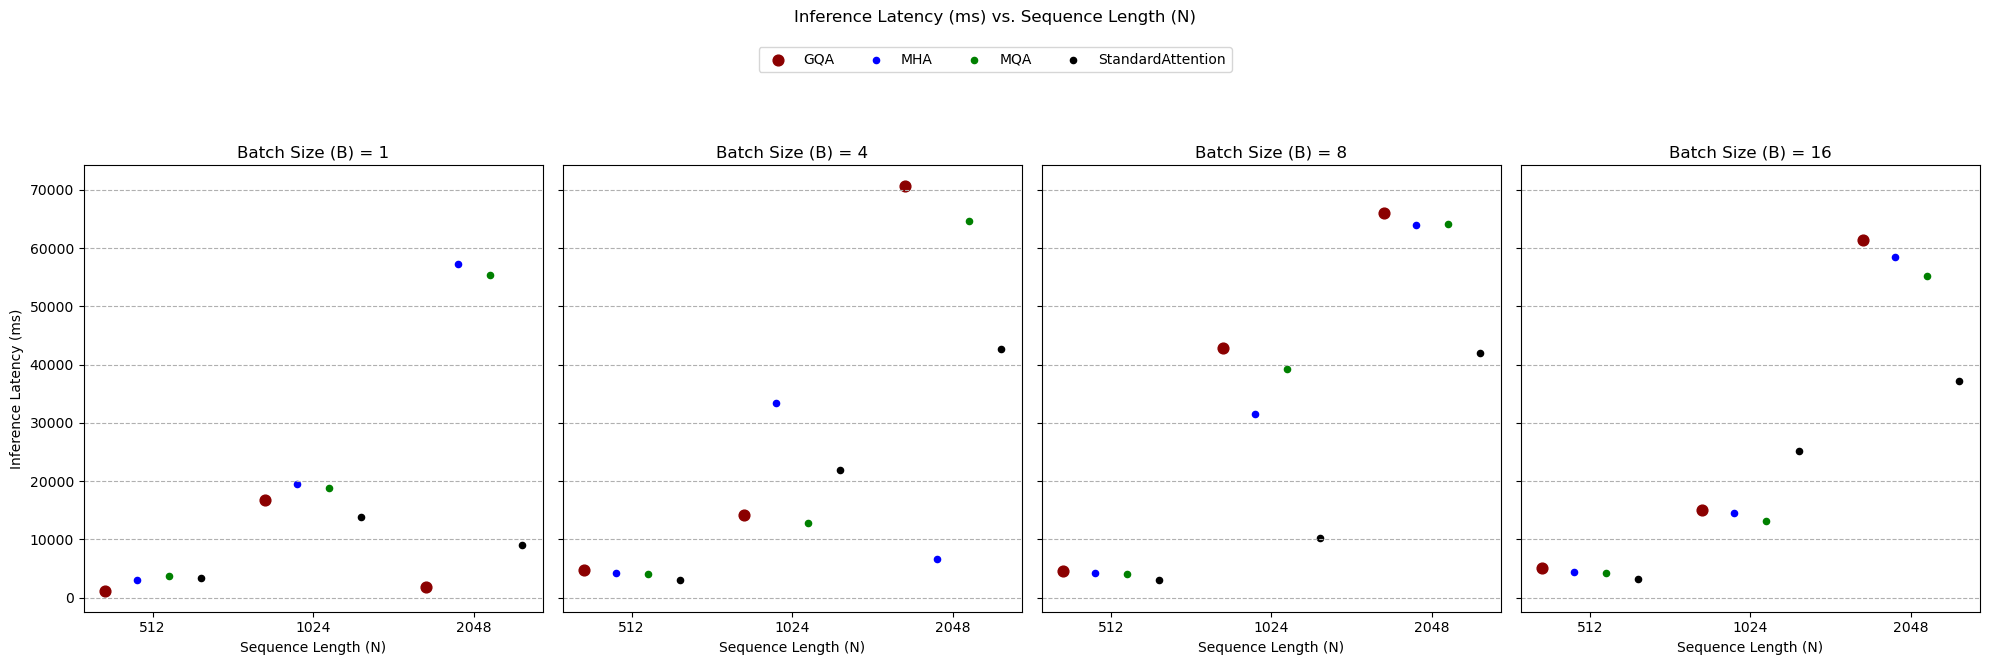

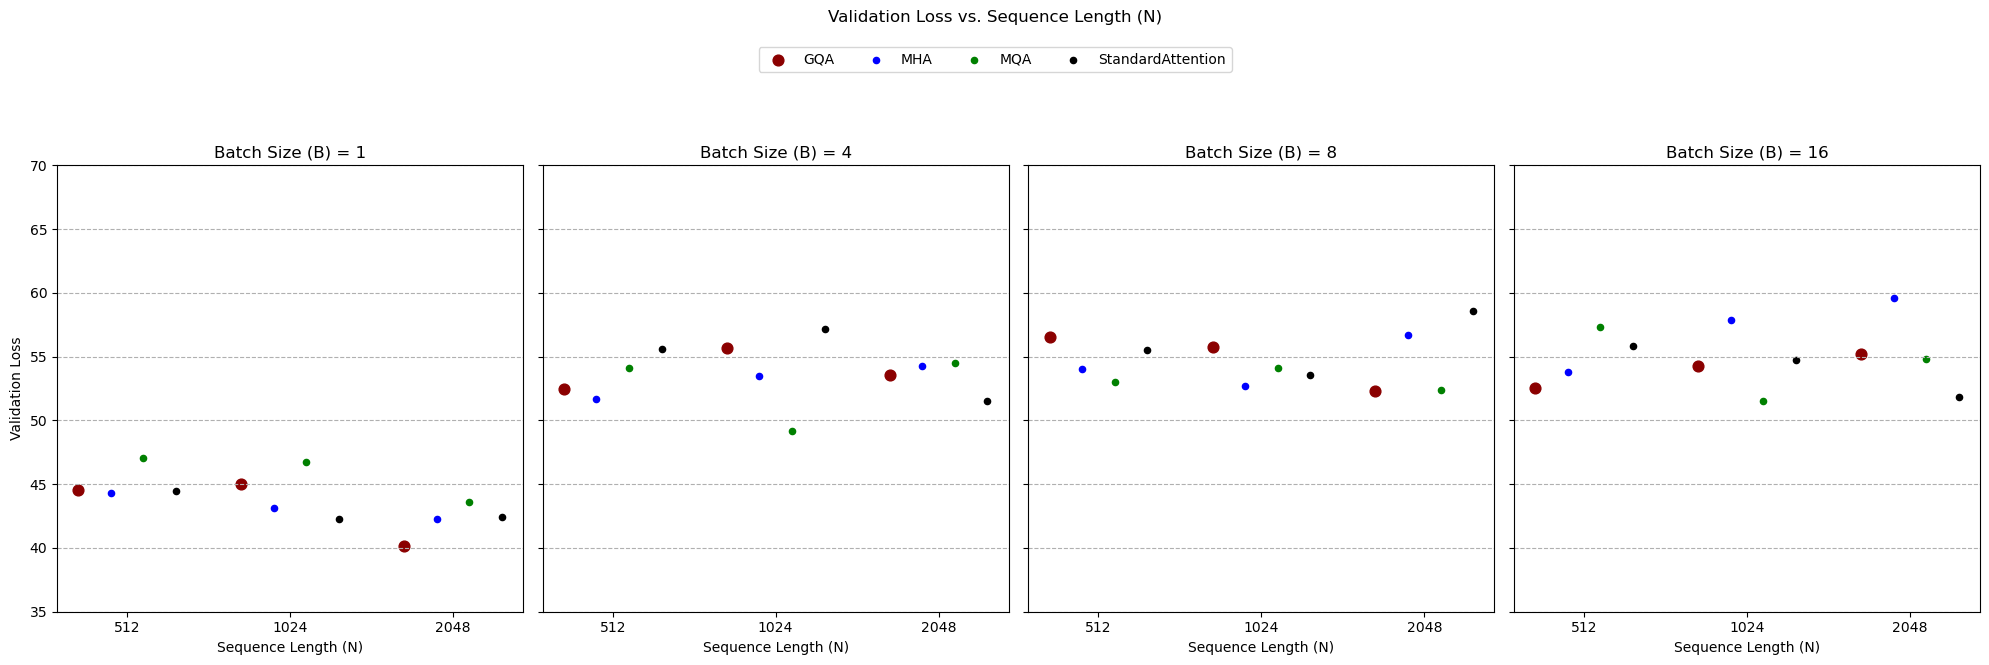

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

data_df = pd.DataFrame(results)
model_names = sorted(data_df['model'].unique().tolist())
N_VALUES = sorted(data_df['N'].unique().tolist())
B_VALUES = sorted(data_df['B'].unique().tolist())

colors = ['darkred', 'blue', 'green', 'black',]

def plot_metric(data_list, metric_key, metric_label, B_VALUES, y_lim=None):
    data_df = pd.DataFrame(data_list)
    model_names = sorted(data_df['model'].unique().tolist())
    N_VALUES = sorted(data_df['N'].unique().tolist())
    num_models = len(model_names)
    bar_width = 0.8 / num_models 
    
    fig, axes = plt.subplots(1, len(B_VALUES), figsize=(5 * len(B_VALUES), 6), sharey=True)
    if len(B_VALUES) == 1: axes = [axes]

    for i, B in enumerate(B_VALUES):
        ax = axes[i]
        B_data_df = data_df.loc[data_df['B'] == B]
        x_base = range(len(N_VALUES)) 

        for j, model_name in enumerate(model_names):
            x_offset = j * bar_width - (bar_width * (num_models - 1) / 2)
            model_data_df = B_data_df.loc[B_data_df['model'] == model_name].sort_values(by='N')
            metric_list = model_data_df[metric_key].tolist()
            x_pos = [x + x_offset for x in x_base]
            # ax.bar(x_pos, metric_list, bar_width, color=colors[j % len(colors)], label=model_name)
            ax.scatter(x_pos, metric_list, color=colors[j % len(colors)], label=model_name, s=60 if model_name == 'GQA' else 20)

        ax.set_title(f'Batch Size (B) = {B}')

        ax.set_xlabel('Sequence Length (N)')
        ax.set_xticks(x_base)
        ax.set_xticklabels([str(n) for n in N_VALUES])

        ax.grid(axis='y', linestyle='--')
        if i == 0: ax.set_ylabel(metric_label)
        if y_lim: ax.set_ylim(y_lim)

    handles, labels = axes[-1].get_legend_handles_labels()
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=num_models)
    
    fig.suptitle(f'{metric_label} vs. Sequence Length (N)', y=1.10)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # plt.savefig(f'{metric_key}_comparison_bar_chart.png')
    
    return f'{metric_key}_comparison_bar_chart.png'

latency_plot_file = plot_metric(results, 'latency_ms', 'Inference Latency (ms)', B_VALUES)
val_loss_plot_file = plot_metric(results, 'val_loss', 'Validation Loss', B_VALUES, y_lim=(35, 70))